# 4.1 - evaluate modified T5 model

In the previous notebook I have modified the T5 model approach we have reviewed in the lab.

In this notebook I will evaluate the modified model in the same way I did with cond BERT to find the rate of toxicity left after transformation of sentences.

## Load model to evaluate toxicity

In [2]:
from transformers import pipeline

# load metrics
import evaluate

# Load the BLUE metric
metric = evaluate.load("sacrebleu")

# load toxicity rate metric
toxicity_rater = pipeline("text-classification", model="martin-ha/toxic-comment-model")

## Load model to be evaluated

In [3]:
# Necessary inputs
import warnings
import argparse
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np

warnings.filterwarnings("ignore")


def translate(model, inference_request, tokenizer):
    """
    translate is helper function which allows easier inference of model

    Args:
        model (transformers.modeling_utils.PreTrainedModel): model to use for inference
        inference_request (str): input string to transform
        tokenizer (transformers.tokenization_utils.PreTrainedTokenizer): tokenizer to use for inference
    """
    prefix = "paraphrase toxic sentences:"
    input_ids = tokenizer(prefix + inference_request, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True, temperature=0)


# load model
model = AutoModelForSeq2SeqLM.from_pretrained("./../models/best")

# get tokenizer from model
tokenizer = AutoTokenizer.from_pretrained("./../models/best")

## Load dataset for evaluation

In [4]:
import pandas as pd

# load validation dataset
df = pd.read_csv("../data/interim/val_subset.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
314081,But the French will hog them all.,but I guess the French will eat them.,0.640306,0.105263,0.930104,0.001689
284848,Gay? Oh! I can't even say it.,I can't even say.,0.680517,0.400000,0.982420,0.000055
148298,"He come round at night, kicked my door in, dra...","he came out that night, knocked out the door, ...",0.730038,0.243697,0.995085,0.002226
211184,Of course he rolled his fucking eyes!,that's why he rolled his eyes.,0.710801,0.184211,0.998498,0.000072
14849,I'm the fucking customer here!,I'm your customer!,0.845089,0.387097,0.995472,0.000044


In [5]:
def evaluate(sentence):
    """
    evaluate is helper function which computes bleu score and toxicity rate
    after sentence transformation
    """

    result = translate(model, sentence, tokenizer)

    # calculate scores
    bleu_score = metric.compute(predictions=[result], references=[[sentence]])["score"]

    # evaluate toxicity
    toxicity = toxicity_rater(result)[0]

    return {
        "sentence": result,
        "bleu_score": bleu_score,
        "rate": toxicity["score"] * (-1 if toxicity["label"] == "toxic" else 1),
    }


evaluate(df["translation"].iat[0])

{'sentence': 'but I guess the French will eat them.',
 'bleu_score': 100.00000000000004,
 'rate': 0.9976651668548584}

In [6]:
evaluate("I bet it's bullshit favorite secret jerk-off movie.")

{'sentence': "I'm betting it's a favorite movie.",
 'bleu_score': 11.737849637633069,
 'rate': 0.9991325736045837}

In [7]:
from tqdm import tqdm

history = []

for sentence in tqdm(df["reference"]):
    history.append(evaluate(sentence))

100%|██████████| 500/500 [04:13<00:00,  1.97it/s]


In [8]:
# save as pandas dataframe for further comparison
history_df = pd.DataFrame(history)
history_df.to_csv("../data/evaluations/t5_finetuned.csv", index=False)

history_df.head()

,sentence,bleu_score,rate
0,but the French will be able to do it all.,17.542198,0.998859
1,I can't even say it.,51.341712,0.998648
2,"he come round at night, kicked my door in, dra...",38.898854,0.994083
3,he rolled his eyes!,27.440582,0.997702
4,I'm the customer here!,40.936538,0.998950


# Analysis:

As compared to the cond BERT approach I have presented in `3.0-evaluate-bert`, the T5 model is much more effective in reducing the toxicity of the sentences.

However, rating the BLEU score it is less effective in preserving the meaning of the sentences, but I believe that this score remained high in cond BERT because of words replacement, whereas T5 model can paraphrase and change the structure of the sentence.


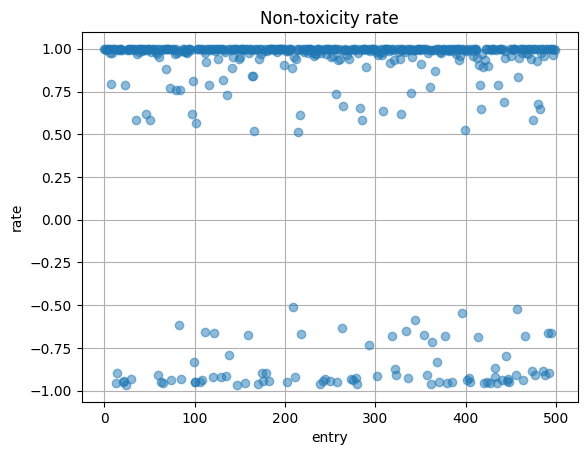

In [10]:
import sys

# to be able to load modules from src
sys.path.append("..")

from src.visualization.utils import simple_hist, simple_plot

simple_plot(
    history_df["rate"],
    title="Non-toxicity rate",
    xlabel="entry",
    ylabel="rate",
    save_path="../reports/figures/t5_rate.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

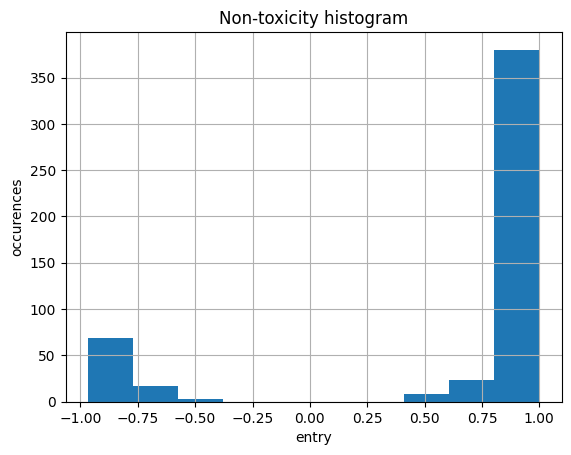

In [11]:
simple_hist(
    history_df["rate"],
    title="Non-toxicity histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/t5_rate_hist.png",
)

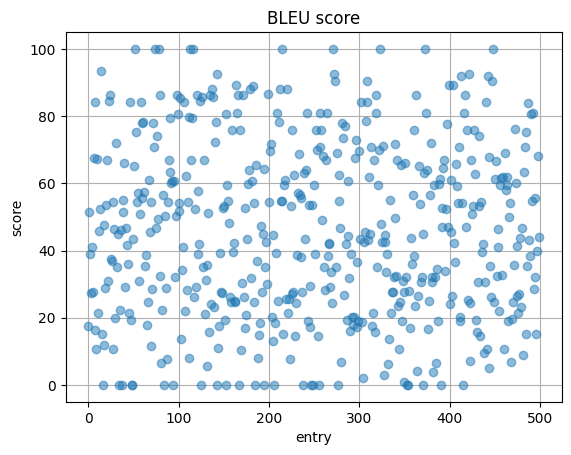

In [12]:
simple_plot(
    history_df["bleu_score"],
    title="BLEU score",
    xlabel="entry",
    ylabel="score",
    save_path="../reports/figures/t5_bleu.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

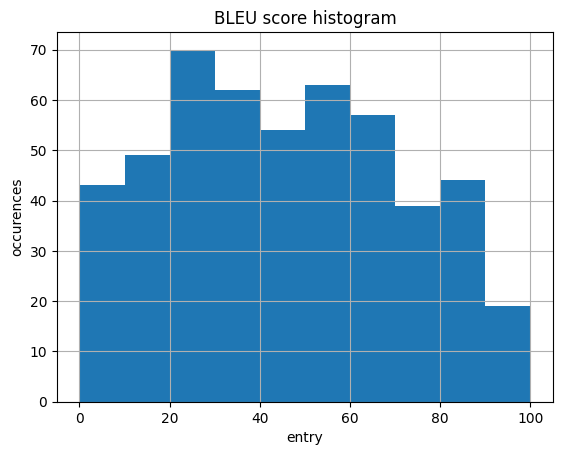

In [13]:
simple_hist(
    history_df["bleu_score"],
    title="BLEU score histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/t5_bleu_hist.png",
)